# Sewer network example

This example demonstrates the use of pysewer to generate a sewer network using the the following data inputs:
- A digital elevation model (DEM)
- Road network data
- Building footprint data

In this example the road and building data are generated using the [OSMnx] package.

The network is generated using the following steps:
1. Preprocessing of the input data. This involves setting input parameters and converting the input data to the correct format. This is then followed by instantiation of the network using pysewer.ModelDomain
2. Application of the routing algorithm to generate the sewer network. This is done using repeated shortest path heuristic (RSPH) algorithm. This is done using pysewer.rsph_tree ()
3. Hydraulic calculations and pump optimization 
4. Post processing of the results
5. Export of the generated sewer network to a geopackage file using the pysewer.export module. Shapefiles and geoparquet files are also supported.

## Preprocessing


In [1]:
import pysewer
import matplotlib.pyplot as plt
import networkx as nx
from pysewer.config.settings import load_config, config_to_dataframe  # load the the settings file 
from pysewer.export import export_sewer_network

### Load custom settings 
The customs settings are stored in yaml file within the notebook. The settings are loaded using the pysewer.config.settings.load_config function. This created a Config class from which settings are then passed to the pysewer.ModelDomain class to initialise the model domain.

Note the defaults settings are stored within the pysewer package. These can be viewed using the pysewer.config.settings.view_default_settings function.

The settings file is dived into 4 sections:
1. the preprocessing parameters settings
2. the optimization parameter settings. Use for carrying out the hydraulic calculations and pump optimization
3. the plot settings
4. the export settings

To change the settings, the user can either edit the yaml file or change the settings directly using the Config class. For example, to change the minimum trench depth of the sewer pipes to 1 m in the example_settings.yaml file, the user can change the following line:

```yaml
optimization:
  min_trench_depth: 0.5
```

Finally, one can display the final settings that would be used to initalise the mode.

In [2]:
# load custom settings from the example settings file
custom_config = load_config("./example_settings.yaml")
df_config = config_to_dataframe(custom_config)
display(df_config)

,Setting,Value
0,preprocessing_dem_file_path,example_data/1_DEM/dem_10m1.tif
1,preprocessing_roads_input_data,example_data/3_Roads/roads_projected.shp
2,preprocessing_buildings_input_data,example_data/2_Buildings/buildings_projected.shp
3,preprocessing_dx,10
4,preprocessing_pump_penalty,1000
5,preprocessing_max_connection_length,30
6,preprocessing_clustering,none
7,preprocessing_connect_buildings,True
8,preprocessing_add_private_sewer,True
9,preprocessing_field_get_sinks,node_type


In [3]:
# Instantiate the model domain
test_model_domain = pysewer.ModelDomain(
    dem=custom_config.preprocessing.dem_file_path,
    buildings=custom_config.preprocessing.buildings_input_data,
    roads=custom_config.preprocessing.roads_input_data,
    clustering=custom_config.preprocessing.clustering,
)

/Users/despot/miniconda3/envs/pysewer/lib/python3.10/site-packages/shapely/linear.py:208: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/Users/despot/miniconda3/envs/pysewer/lib/python3.10/site-packages/shapely/linear.py:208: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/Users/despot/miniconda3/envs/pysewer/lib/python3.10/site-packages/shapely/linear.py:208: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/Users/despot/miniconda3/envs/pysewer/lib/python3.10/site-packages/shapely/linear.py:208: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/Users/despot/miniconda3/envs/pysewer/lib/python3.10/site-packages/shapely/linear.py:208: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/Users/despot/miniconda3/envs/pysewer/li

In [4]:
# setting and adding the sinks. Sinks are the lowest points in the model domain where WWTP are considered to be located. 
test_model_domain.set_sink_lowest()
test_model_domain.add_sink((690500, 2557000))

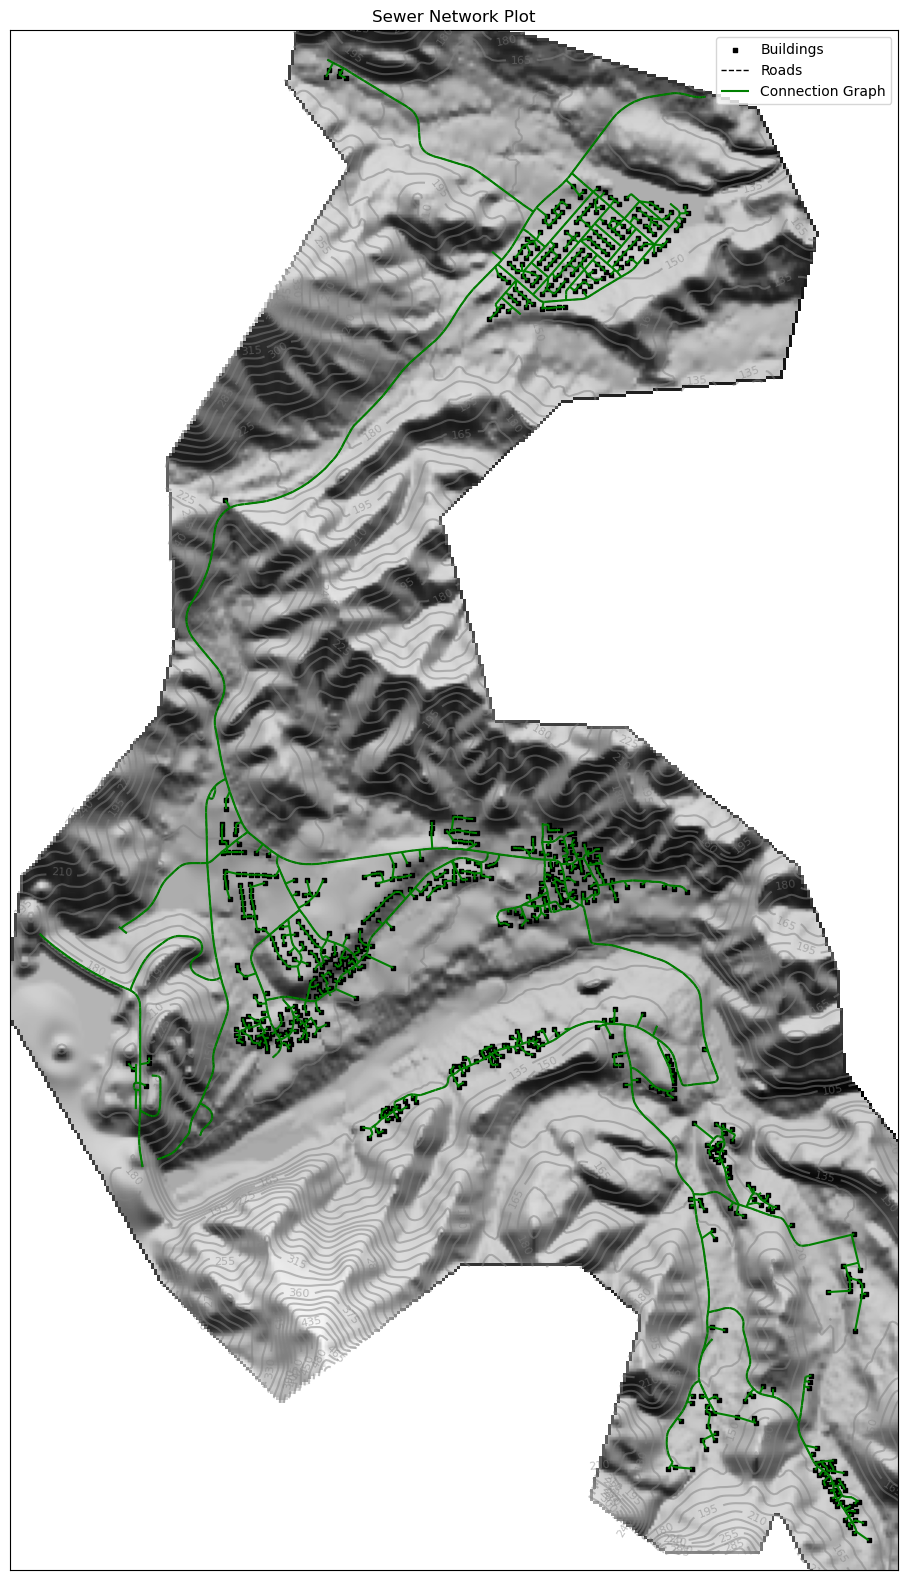

In [5]:
fig, ax = pysewer.plot_model_domain(
    test_model_domain,
    plot_connection_graph=custom_config.plotting.plot_connection_graph,
    hillshade=custom_config.plotting.hillshade,
)

In [6]:
# preview the the buildings geoDataFrame
test_model_domain.buildings.get_gdf().head()


,OID_,Name,FolderPath,SymbolID,AltMode,Base,Snippet,PopupInfo,HasLabel,LabelID,...,POINT_M,Q,Einw_GEB,NEAR_FID,NEAR_DIST,NEAR_X,NEAR_Y,POINT_X,POINT_Y,geometry
0,0,Building,Mazarih_buildings.kmz/Mazarih_buildings,0,-1,0.0,NaN,NaN,-1,0,...,NaN,2,2,108,24.984560,689738.466001,2.554467e+06,689713.6976,2.554464e+06,POINT (689713.698 2554463.950)
1,0,Building,Mazarih_buildings.kmz/Mazarih_buildings,0,-1,0.0,NaN,NaN,-1,0,...,NaN,2,2,108,17.414640,689743.517334,2.554438e+06,689726.4170,2.554435e+06,POINT (689726.417 2554434.914)
2,0,Building,Mazarih_buildings.kmz/Mazarih_buildings,0,-1,0.0,NaN,NaN,-1,0,...,NaN,2,2,142,10.155101,689724.692601,2.554415e+06,689729.2341,2.554405e+06,POINT (689729.234 2554405.482)
3,0,Building,Mazarih_buildings.kmz/Mazarih_buildings,0,-1,0.0,NaN,NaN,-1,0,...,NaN,2,2,107,16.089287,689729.748675,2.554375e+06,689743.8734,2.554382e+06,POINT (689743.873 2554382.425)
4,0,Building,Mazarih_buildings.kmz/Mazarih_buildings,0,-1,0.0,NaN,NaN,-1,0,...,NaN,2,2,107,11.837779,689723.424042,2.554386e+06,689713.0317,2.554381e+06,POINT (689713.032 2554380.648)


In [7]:
# create the the graph conections
# this to be used for the routing algorithm
connection_graph = test_model_domain.generate_connection_graph()

3374
1359
Simplified graph: 3374 to 1334 nodes, 3912 to 1871 edges


In [8]:
# get the sinks within the area of interest. 
# verify that the sinks were addeded
test_model_domain.get_sinks()

[(691258.1220546402, 2554226.804832181), (690500.0, 2557000.0)]

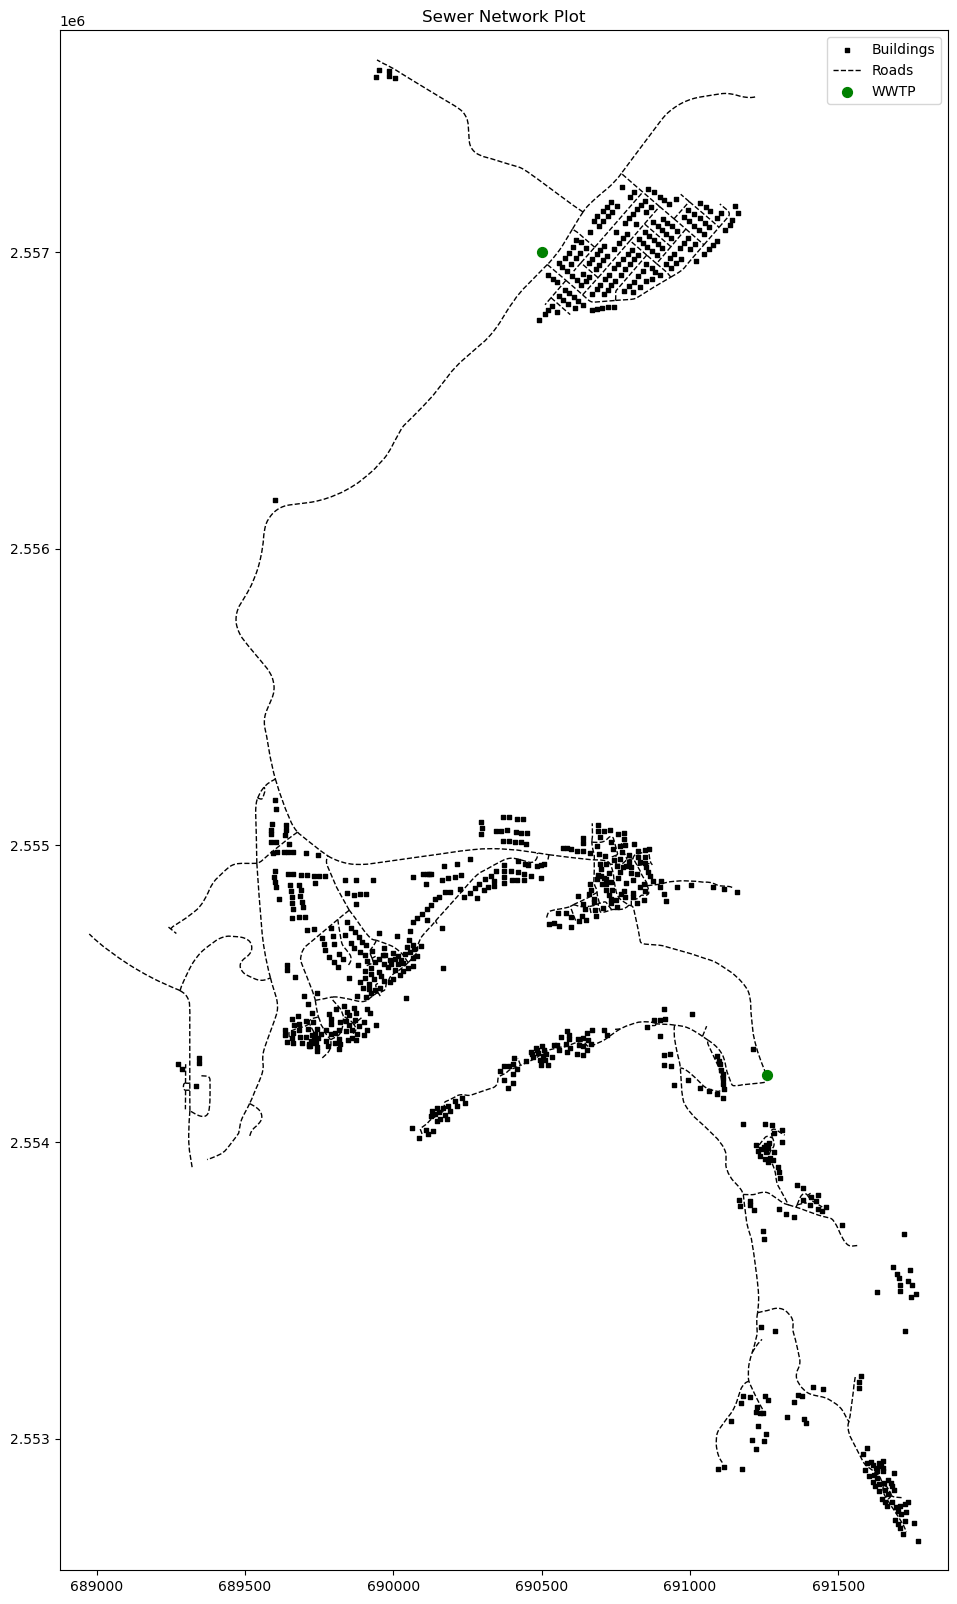

In [9]:
fig, ax = pysewer.plot_model_domain(
    test_model_domain, plot_sink=custom_config.plotting.plot_sink
)

## Routing Solver

For the network routing, an rhsp tree growing algorithm was implemented.


In [10]:
layout = pysewer.rsph_tree(connection_graph, test_model_domain.get_sinks(), "building")

No pumping station in the sewer graph
Plotting sewer graph without pumping station


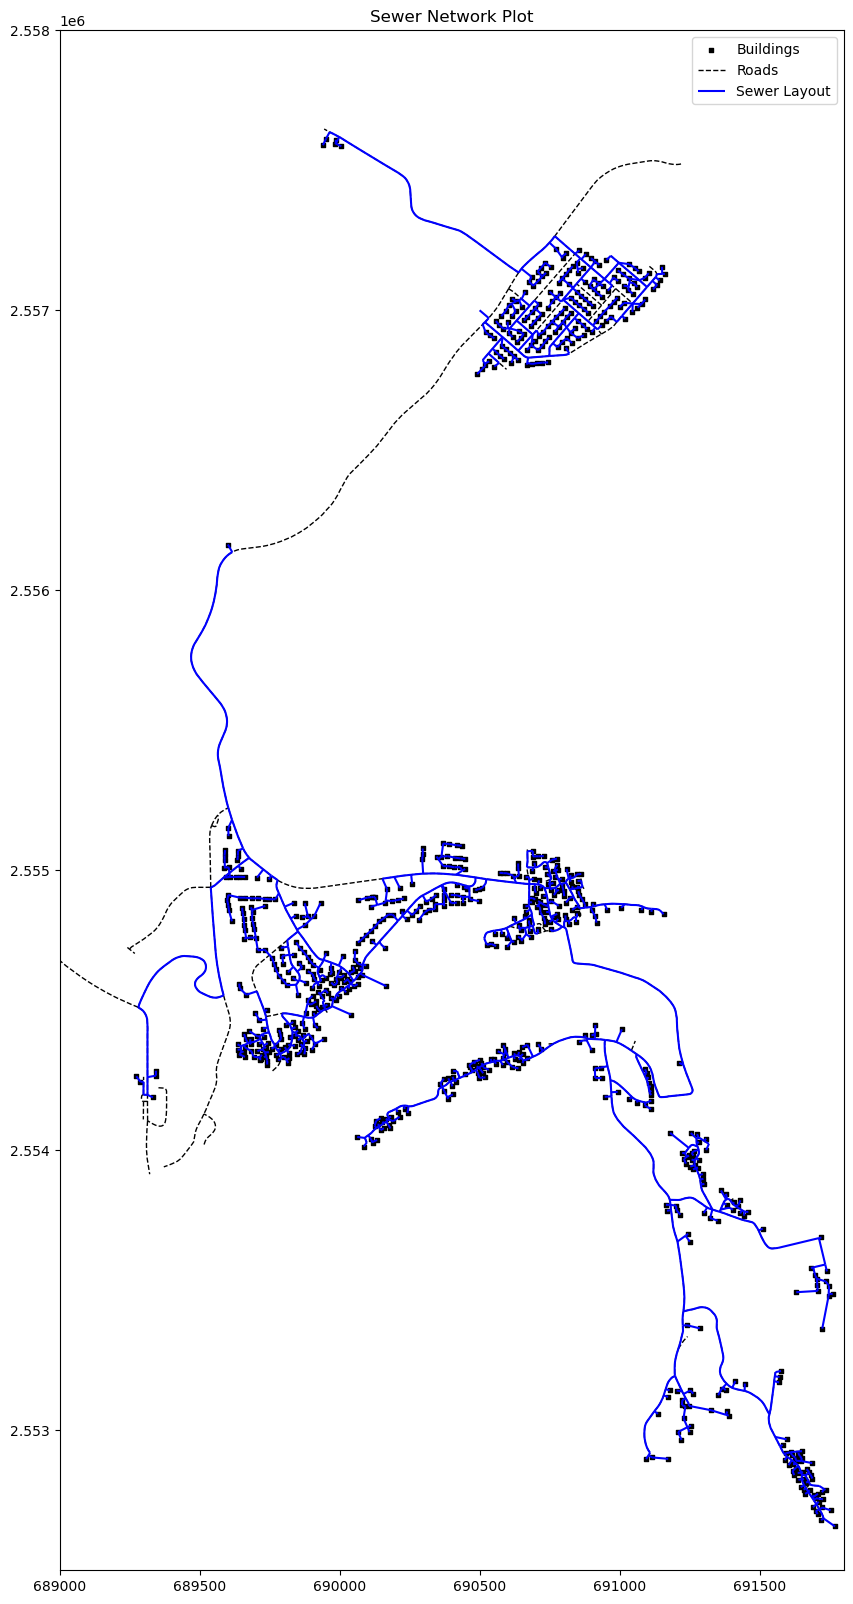

In [11]:
fig, ax = pysewer.plot_model_domain(
    test_model_domain, plot_sewer=True, sewer_graph=layout
)
ax.set_xlim(689000, 691800)
ax.set_ylim(2552500, 2558000)
plt.show()

## Pump Optimization


0


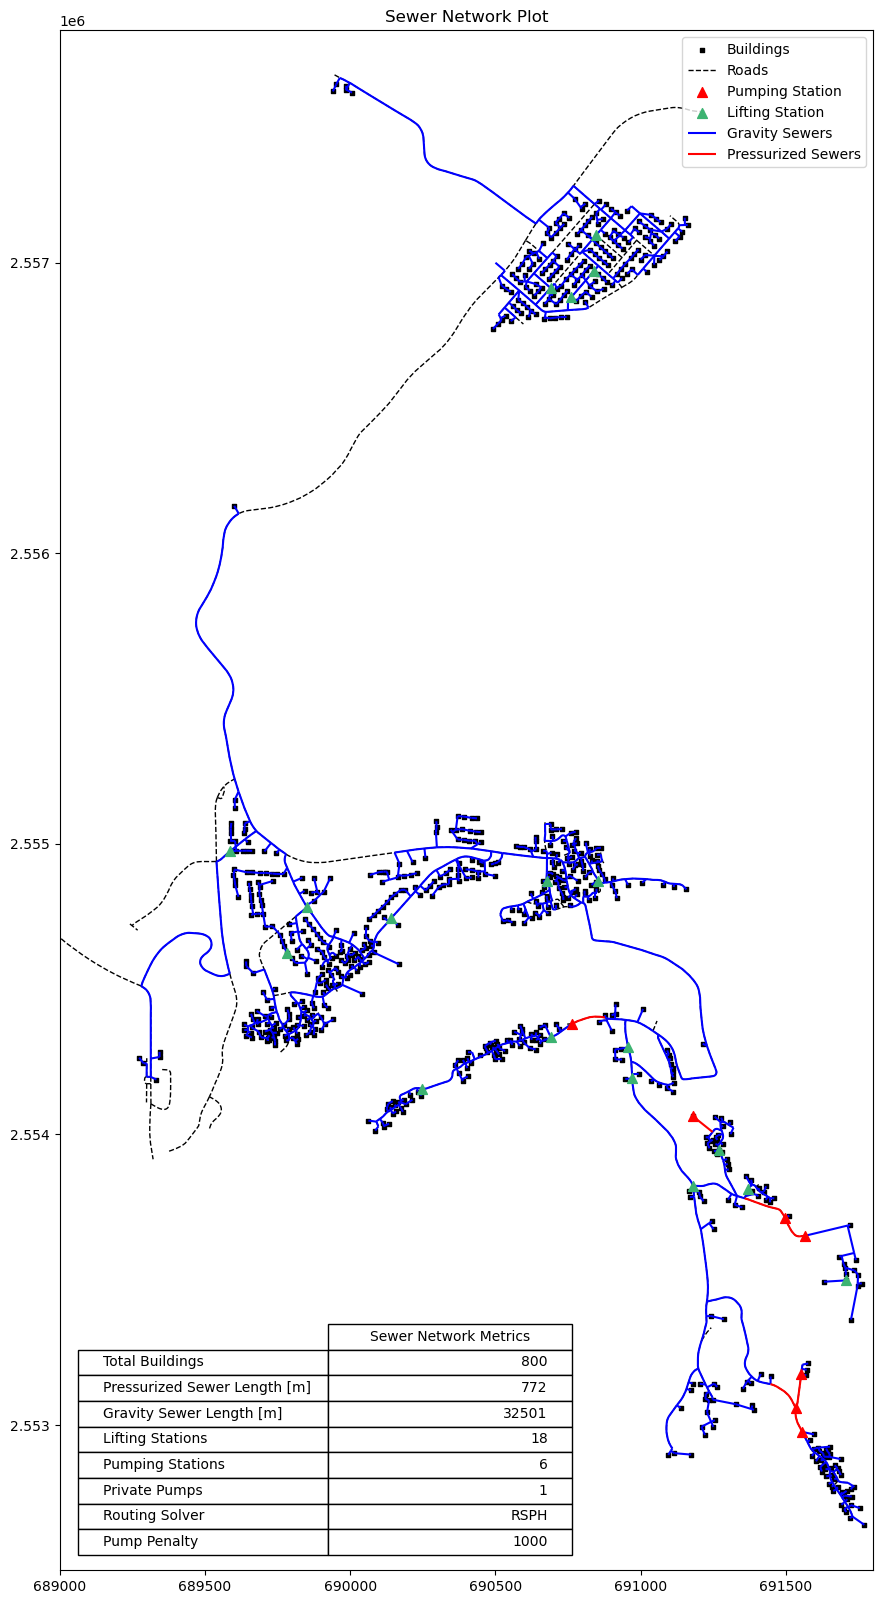

In [12]:
G = pysewer.estimate_peakflow(
    layout,
    inhabitants_dwelling=custom_config.optimization.inhabitants_dwelling,
    daily_wastewater_person=custom_config.optimization.daily_wastewater_person,
)
G = pysewer.calculate_hydraulic_parameters(
    layout,
    sinks=test_model_domain.get_sinks(),
    diameters=custom_config.optimization.diameters,
    pressurized_diameter=custom_config.optimization.pressurized_diameter,
    include_private_sewer=True,
    roughness=custom_config.optimization.roughness,
)
info = pysewer.get_sewer_info(G)
info["Routing Solver"] = "RSPH"
info["Pump Penalty"] = test_model_domain.pump_penalty
fig, ax = pysewer.plot_model_domain(
    test_model_domain, plot_sewer=True, sewer_graph=G, info_table=info
)
ax.set_xlim(689000, 691800)
ax.set_ylim(2552500, 2557800)

ax.set_title("Sewer Network Plot")
plt.legend(loc="upper right")
plt.show()

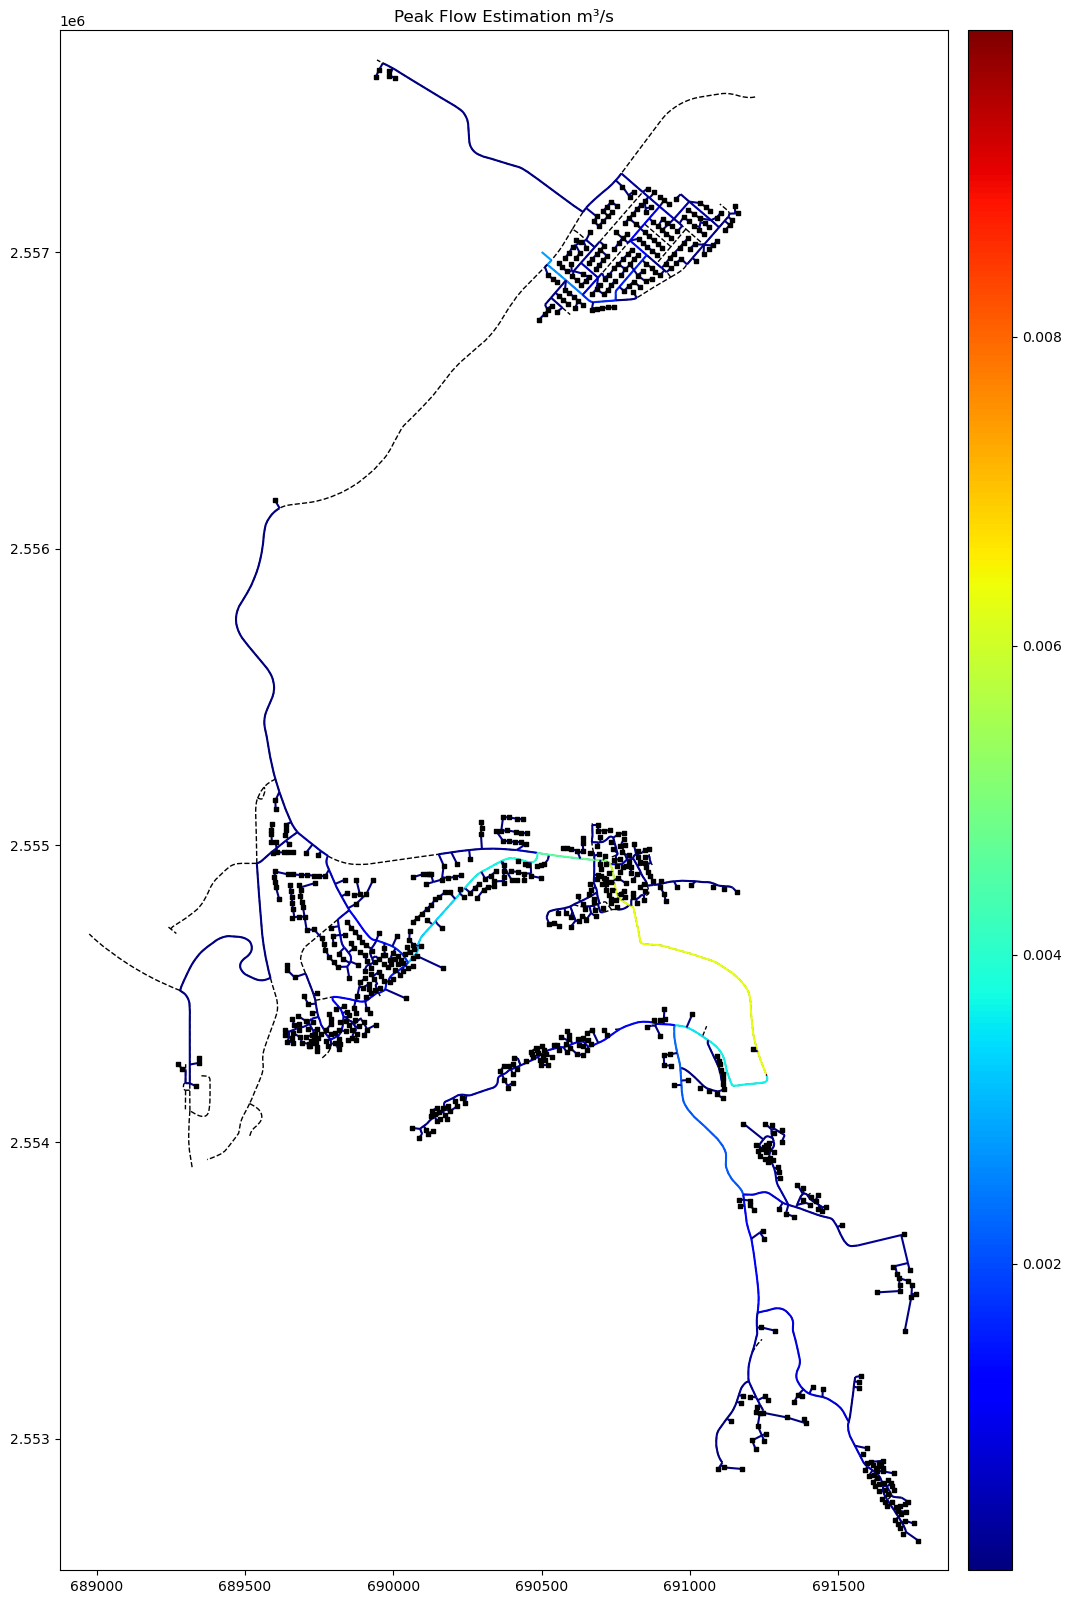

In [13]:
pysewer.plot_sewer_attributes(
    test_model_domain, G, attribute="peak_flow", title="Peak Flow Estimation m³/s"
)
plt.show()

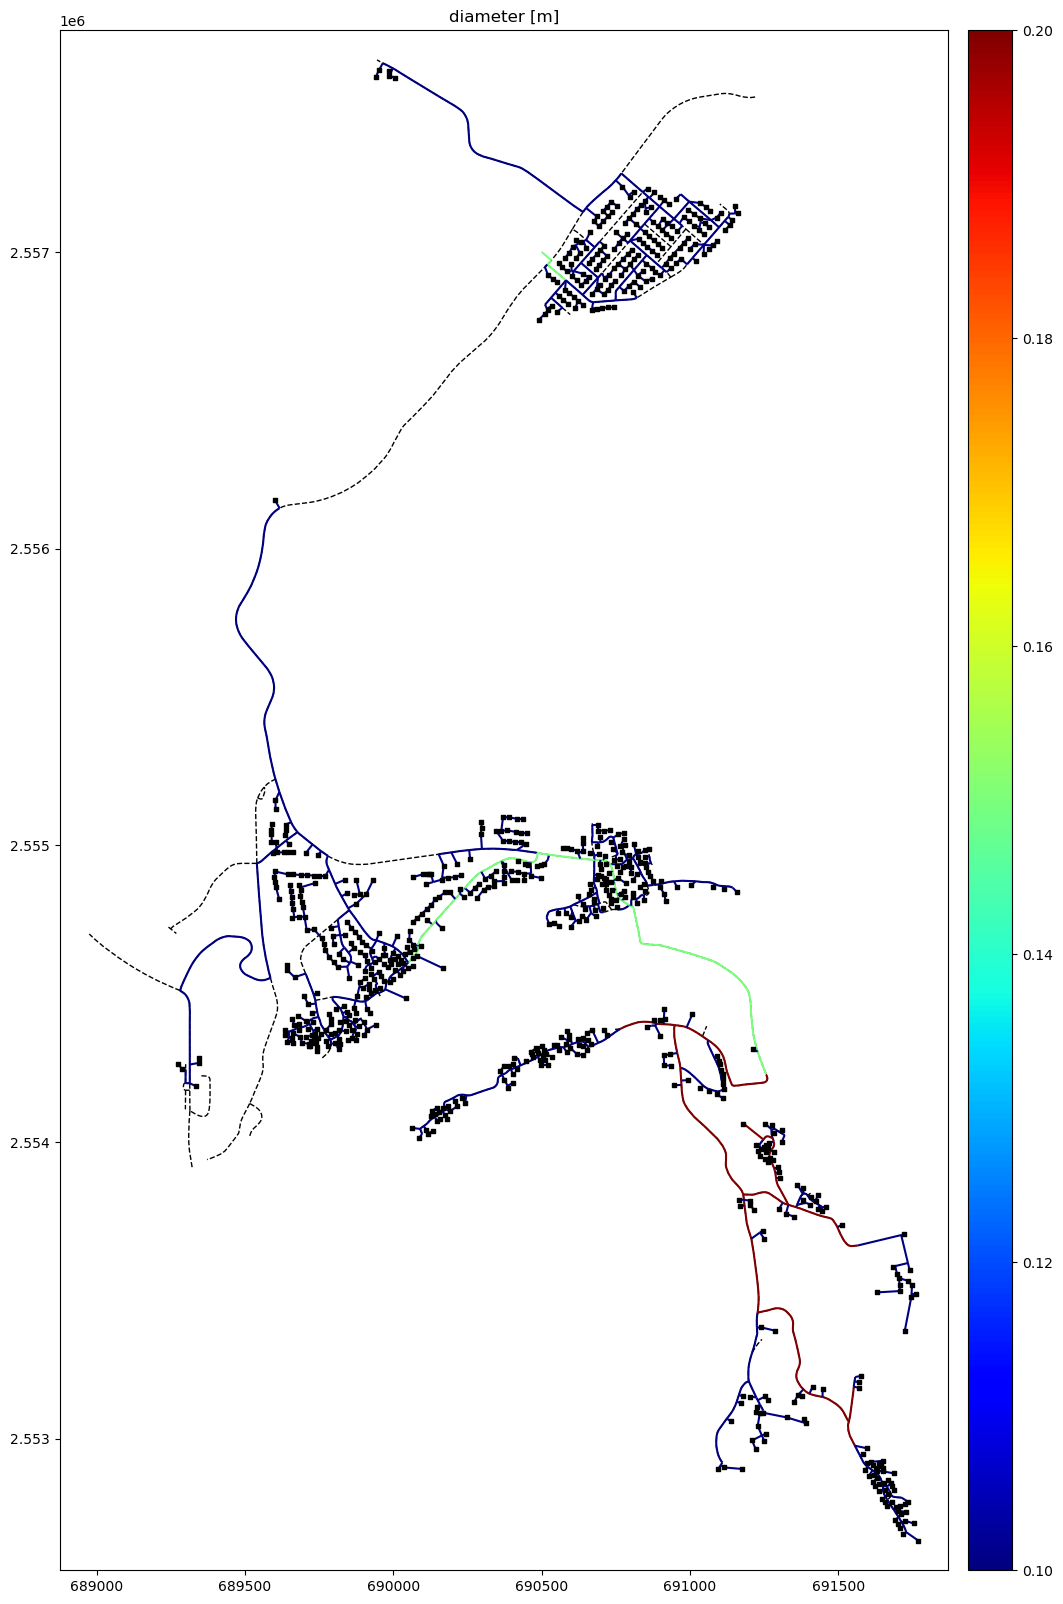

In [14]:
pysewer.plot_sewer_attributes(
    test_model_domain, G, attribute="diameter", title="diameter [m]"
)
plt.show()

## Export Sewer Network


In [15]:


sewer_network_gdf = pysewer.get_edge_gdf(G, detailed=True)
pysewer.export_sewer_network(sewer_network_gdf, "sewer_network.gpkg")

Successfully exported sewer network to sewer_network.gpkg.


In [16]:
# check the file that was created 
import geopandas as gpd
sn_gdf = gpd.read_file("sewer_network.gpkg")
sn_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1295 entries, 0 to 1294
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   distance              1295 non-null   float64 
 1   profile               1295 non-null   object  
 2   needs_pump            1295 non-null   object  
 3   weight                1295 non-null   float64 
 4   pressurized           1295 non-null   object  
 5   trench_depth_profile  1295 non-null   object  
 6   mean_td               1295 non-null   float64 
 7   diameter              1295 non-null   float64 
 8   peak_flow             1295 non-null   float64 
 9   edge_counter          1295 non-null   int64   
 10  OBJECTID              24 non-null     float64 
 11  SUBTYPELBL            1295 non-null   object  
 12  ROADNAMEA             1295 non-null   object  
 13  ROADNAMEE             1295 non-null   object  
 14  ROADNO                24 non-null     float64 
 

In [17]:
sewer_network_gdf = pysewer.get_edge_gdf(G, detailed=True)
sewer_network_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1295 entries, 0 to 1294
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   geometry              1295 non-null   geometry
 1   distance              1295 non-null   float64 
 2   profile               1295 non-null   object  
 3   needs_pump            1295 non-null   bool    
 4   weight                1295 non-null   float64 
 5   pressurized           1295 non-null   bool    
 6   trench_depth_profile  1295 non-null   object  
 7   mean_td               1295 non-null   float64 
 8   diameter              1295 non-null   float64 
 9   peak_flow             1295 non-null   float64 
 10  edge_counter          1295 non-null   int64   
 11  OBJECTID              24 non-null     float64 
 12  SUBTYPELBL            24 non-null     object  
 13  ROADNAMEA             7 non-null      object  
 14  ROADNAMEE             7 non-null      object  
 

In [18]:
# try using geoparquet to save the geodataframe
sewer_network_gdf.to_parquet("sewer_parq.parquet", index=False)

/var/folders/ft/8qzbkr994y9gmhkqb5l97lsw0000gq/T/ipykernel_69364/1793822407.py:2: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  sewer_network_gdf.to_parquet("sewer_parq.parquet", index=False)


In [19]:
test_parq = gpd.read_parquet("sewer_parq.parquet")
test_parq.info()
test_parq

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1295 entries, 0 to 1294
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   geometry              1295 non-null   geometry
 1   distance              1295 non-null   float64 
 2   profile               1295 non-null   object  
 3   needs_pump            1295 non-null   bool    
 4   weight                1295 non-null   float64 
 5   pressurized           1295 non-null   bool    
 6   trench_depth_profile  1295 non-null   object  
 7   mean_td               1295 non-null   float64 
 8   diameter              1295 non-null   float64 
 9   peak_flow             1295 non-null   float64 
 10  edge_counter          1295 non-null   int64   
 11  OBJECTID              24 non-null     float64 
 12  SUBTYPELBL            24 non-null     object  
 13  ROADNAMEA             7 non-null      object  
 14  ROADNAMEE             7 non-null      object  
 

,geometry,distance,profile,needs_pump,weight,pressurized,trench_depth_profile,mean_td,diameter,peak_flow,edge_counter,OBJECTID,SUBTYPELBL,ROADNAMEA,ROADNAMEE,ROADNO,SHAPE_Leng,Shape_Le_1,private_sewer
0,"LINESTRING (691331.435 2553788.287, 691320.033...",20.134885,"[[0.0, 127.91], [10.0, 127.53], [20.0, 127.29]...",False,20.134885,False,"[[0.0, 121.04193127104296], [10.0, 120.9419312...",6.588406,0.20,0.000783,942,NaN,None,None,None,NaN,NaN,NaN,None
1,"LINESTRING (691357.594 2553780.200, 691331.435...",27.380986,"[[0.0, 127.13], [10.0, 127.33], [20.0, 127.33]...",False,27.380986,False,"[[0.0, 121.46418046388283], [10.0, 121.3641804...",6.104272,0.20,0.000383,926,8696.0,WAY,شارع الظاهر,al Dhahir Street,0.0,292.3177,292.272612,None
2,"LINESTRING (691565.568 2553651.218, 691547.448...",104.614016,"[[0.0, 113.2], [10.0, 113.57], [20.0, 113.99],...",True,104614.016341,True,"[[0.0, 0.25], [104.61401634135458, 0.25]]",113.135000,0.20,0.000208,896,NaN,None,None,None,NaN,NaN,NaN,None
3,"LINESTRING (691395.982 2553820.064, 691395.227...",14.633401,"[[0.0, 118.94], [10.0, 118.16], [14.6334005377...",False,14.633401,False,"[[0.0, 115.71538742613285], [10.0, 115.6153874...",3.070057,0.10,0.000096,833,NaN,None,None,None,NaN,NaN,NaN,None
4,"LINESTRING (691404.979 2553807.972, 691396.500...",15.073645,"[[0.0, 120.23], [10.0, 118.94], [15.0736449201...",False,15.073645,False,"[[0.0, 115.8661238753348], [10.0, 115.76612387...",3.587455,0.10,0.000096,806,NaN,None,None,None,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1290,"LINESTRING (689998.543 2557618.964, 690002.888...",845.262142,"[[0.0, 173.19], [10.0, 172.68], [20.0, 172.37]...",False,845.262142,False,"[[0.0, 171.25243193892874], [10.0, 171.1524319...",0.638117,0.10,0.000080,1060,NaN,None,None,None,NaN,NaN,NaN,None
1291,"LINESTRING (690006.435 2557585.302, 689986.444...",22.532219,"[[0.0, 171.99], [10.0, 172.02], [20.0, 172.47]...",False,22.532219,False,"[[0.0, 171.74], [10.0, 171.64000000000001], [2...",0.768831,0.10,0.000016,1044,NaN,None,None,None,NaN,NaN,NaN,None
1292,"LINESTRING (689986.444 2557595.698, 689998.543...",26.224587,"[[0.0, 173.03], [10.0, 173.03], [20.0, 173.02]...",False,26.224587,False,"[[0.0, 171.51467781073515], [10.0, 171.4146778...",1.693384,0.10,0.000048,1053,NaN,None,None,None,NaN,NaN,NaN,None
1293,"LINESTRING (689986.635 2557608.770, 689986.444...",13.073546,"[[0.0, 173.46], [10.0, 173.03], [13.0735459550...",False,13.073546,False,"[[0.0, 173.21], [10.0, 172.78], [13.0735459550...",0.260245,0.10,0.000016,1045,NaN,None,None,None,NaN,NaN,NaN,True


In [20]:
sewer_network_gdf

,geometry,distance,profile,needs_pump,weight,pressurized,trench_depth_profile,mean_td,diameter,peak_flow,edge_counter,OBJECTID,SUBTYPELBL,ROADNAMEA,ROADNAMEE,ROADNO,SHAPE_Leng,Shape_Le_1,private_sewer
0,"LINESTRING (691331.435 2553788.287, 691320.033...",20.134885,"[(0.0, 127.91), (10.0, 127.53), (20.0, 127.29)...",False,20.134885,False,"[(0.0, 121.04193127104296), (10.0, 120.9419312...",6.588406,0.20,0.000783,942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"LINESTRING (691357.594 2553780.200, 691331.435...",27.380986,"[(0.0, 127.13), (10.0, 127.33), (20.0, 127.33)...",False,27.380986,False,"[(0.0, 121.46418046388283), (10.0, 121.3641804...",6.104272,0.20,0.000383,926,8696.0,WAY,شارع الظاهر,al Dhahir Street,0.0,292.3177,292.272612,NaN
2,"LINESTRING (691565.568 2553651.218, 691547.448...",104.614016,"[(0.0, 113.2), (10.0, 113.57), (20.0, 113.99),...",True,104614.016341,True,"[(0, 0.25), (104.61401634135458, 0.25)]",113.135000,0.20,0.000208,896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"LINESTRING (691395.982 2553820.064, 691395.227...",14.633401,"[(0.0, 118.94), (10.0, 118.16), (14.6334005377...",False,14.633401,False,"[(0.0, 115.71538742613285), (10.0, 115.6153874...",3.070057,0.10,0.000096,833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"LINESTRING (691404.979 2553807.972, 691396.500...",15.073645,"[(0.0, 120.23), (10.0, 118.94), (15.0736449201...",False,15.073645,False,"[(0.0, 115.8661238753348), (10.0, 115.76612387...",3.587455,0.10,0.000096,806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1290,"LINESTRING (689998.543 2557618.964, 690002.888...",845.262142,"[(0.0, 173.19), (10.0, 172.68), (20.0, 172.37)...",False,845.262142,False,"[(0.0, 171.25243193892874), (10.0, 171.1524319...",0.638117,0.10,0.000080,1060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1291,"LINESTRING (690006.435 2557585.302, 689986.444...",22.532219,"[(0.0, 171.99), (10.0, 172.02), (20.0, 172.47)...",False,22.532219,False,"[(0.0, 171.74), (10.0, 171.64000000000001), (2...",0.768831,0.10,0.000016,1044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1292,"LINESTRING (689986.444 2557595.698, 689998.543...",26.224587,"[(0.0, 173.03), (10.0, 173.03), (20.0, 173.02)...",False,26.224587,False,"[(0.0, 171.51467781073515), (10.0, 171.4146778...",1.693384,0.10,0.000048,1053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1293,"LINESTRING (689986.635 2557608.770, 689986.444...",13.073546,"[(0.0, 173.46), (10.0, 173.03), (13.0735459550...",False,13.073546,False,"[(0.0, 173.21), (10.0, 172.78), (13.0735459550...",0.260245,0.10,0.000016,1045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
